# Binary classification
---------------------------------

Download the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).
 This dataset tries to predict whether or not it will rain tomorrow by
 training a classification model on target `RainTomorrow`.

### Load the data

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier

# Load the Australian weather dataset
X = pd.read_csv('../weatherAUS.csv')
X = X.drop(['RISK_MM', 'Date'], axis=1)  # Drop unrelated features

### Run the pipeline

In [2]:
# Call ATOM using only a percentage of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, y="RainTomorrow", percentage=5, log='auto', n_jobs=2, verbose=3)

<<=============== ATOM ===============>>
Parallel processing with 2 cores.
Initial data cleaning...
 --> Dropping 45 duplicate rows.
Algorithm task: binary classification.

Dataset stats ===================>
Shape: (7107, 22)
Missing values: 15346
Categorical columns: 5
Scaled: False
----------------------------------
Size of training set: 4974
Size of test set: 2133
----------------------------------
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     5520 |         3867 |        1653 |
| 1: Yes |     1587 |         1107 |         480 |



In [3]:
# If we change a column during the pre-processing,
# we need to call the update method to update all data attributes

atom.X['MaxTemp'] = np.log(atom.X['MaxTemp'])

# MaxTemp has now been changed for atom.X, but not for in atom.X_train, atom.dataset, etc...
# To do se, we do...
atom.update('X')

assert atom.X['MaxTemp'].equals(atom.dataset['MaxTemp'])

In [4]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='missing', max_frac_rows=0.8)

Imputing missing values...
 --> Removing 702 rows for containing too many missing values.
 --> Imputing 4 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 4 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 26 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2318 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2624 missing values using the KNN imputer in feature Sunshine.
 --> Imputing 239 missing values with missing in feature WindGustDir.
 --> Imputing 239 missing values using the KNN imputer in feature WindGustSpeed.
 --> Imputing 309 missing values with missing in feature WindDir9am.
 --> Imputing 24 missing values with missing in feature WindDir3pm.
 --> Imputing 1 missing values using the KNN imputer in feature WindSpeed9am.
 --> Imputing 1 missing values using the KNN imputer in feature WindSpeed3pm.
 --> Imputing 38 missing values using the KNN imputer in feature Humidity9am.
 --> Imput

In [5]:
# Encode the categorical features
atom.encode(max_onehot=10, frac_to_other=0.04)

Encoding categorical features...
 --> Target-encoding feature Location.  Contains 1 unique categories.
 --> Target-encoding feature WindGustDir.  Contains 17 unique categories.
 --> Target-encoding feature WindDir9am.  Contains 17 unique categories.
 --> Target-encoding feature WindDir3pm.  Contains 17 unique categories.
 --> One-hot-encoding feature RainToday. Contains 3 unique categories.


In [6]:
# Select only the best 10 features
atom.feature_selection(strategy="univariate", solver='f_classif', max_features=15, max_correlation=0.8)

# See which features were removed due to collinearity
atom.collinear

Performing feature selection...
 --> Feature Location was removed due to low variance: 0.00.
 --> Feature Pressure3pm was removed due to collinearity with another feature.
 --> Feature Temp9am was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature RainToday_Yes was removed due to collinearity with another feature.
 --> Feature WindSpeed9am was removed after the univariate test (score: 36.90  p-value: 0.00).
 --> Feature WindSpeed3pm was removed after the univariate test (score: 55.43  p-value: 0.00).
 --> Feature RainToday_other was removed after the univariate test (score: 23.65  p-value: 0.00).


,drop_feature,correlated_feature,correlation_value
0,Pressure3pm,Pressure9am,0.96065
1,Temp9am,"MinTemp, MaxTemp","0.90137, 0.87496"
2,Temp3pm,"MaxTemp, Temp9am","0.96166, 0.84807"
3,RainToday_Yes,RainToday_No,-0.98762


In [7]:
# Perform undersampling of the majority class to balance the dataset
atom.balance(undersample=0.8)

Using TensorFlow backend.


Performing undersampling...


In [8]:
# Remove outliers from the training set
atom.outliers(max_sigma=5)

Handling outliers...
 --> Dropping 30 rows due to outliers.


In [9]:
# Change the verbosity of ATOM to not print too much details while fitting
atom.verbose = 2

# Let's use a custom metric
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Let's compare the performance of various gradient boosting algorithms
atom.pipeline(['gbm', 'lgb', 'catb'],
              metric=f2_score,
              max_iter=5,
              init_points=5,
              cv=1,
              bagging=5)


Running pipeline =================>
Models in pipeline: GBM, LGB, CatB
Metric: f2_score


Running BO for Gradient Boosting Machine...
Final results for Gradient Boosting Machine:         
Bayesian Optimization ---------------------------
Best hyperparameters: {'n_estimators': 348, 'learning_rate': 1.0, 'subsample': 1.0, 'max_depth': 4, 'max_features': 0.6, 'criterion': 'mse', 'min_samples_split': 7, 'min_samples_leaf': 8, 'ccp_alpha': 0.0}
Best score on the BO: 0.7208
Time elapsed: 36.286s
Fitting -----------------------------------------
Score on the training set: 1.0000
Score on the test set: 0.5660
Time elapsed: 1.601s
Bagging -----------------------------------------
Mean: 0.5531   Std: 0.0154
Time elapsed: 3.781s
-------------------------------------------------
Total time: 41.672s


Running BO for LightGBM...
Final results for LightGBM:         
Bayesian Optimization ---------------------------
Best hyperparameters: {'n_estimators': 500, 'learning_rate': 0.75, 'max_depth': 10, '

### Analyze the results

In [10]:
# Let's have a look at the best model
print('And the winner is...', atom.winner.longname)

print('Score on the training set: ', atom.winner.score_train)
print('Score on the test set: ', atom.winner.score_test)

And the winner is... CatBoost
Score on the training set:  1.0
Score on the test set:  0.5860702151755378


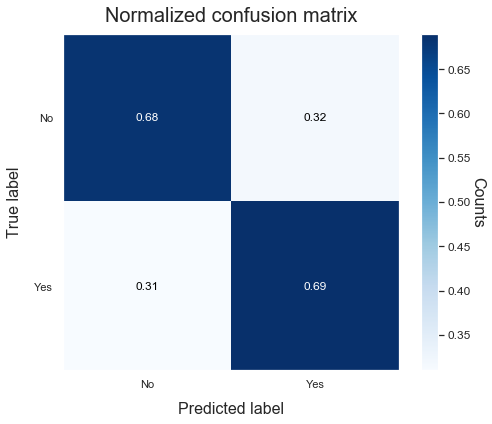

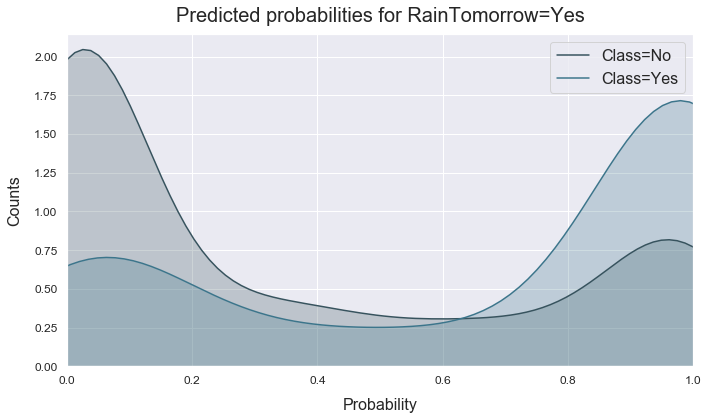

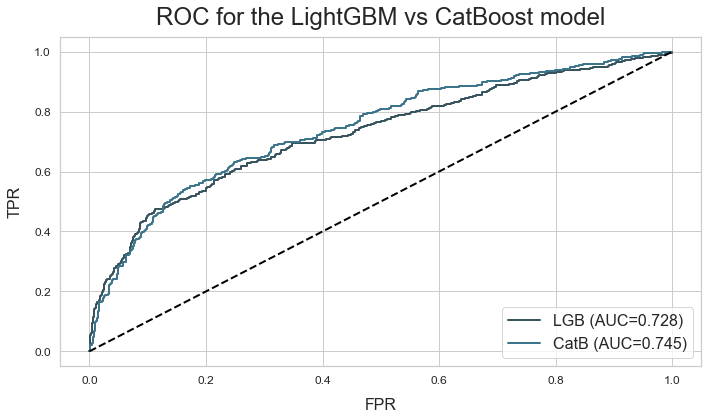

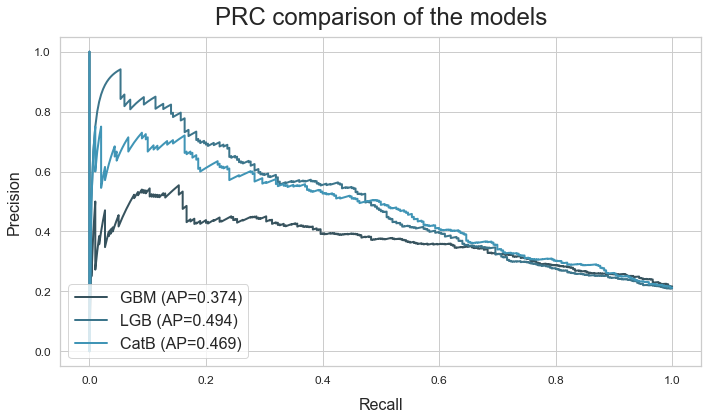

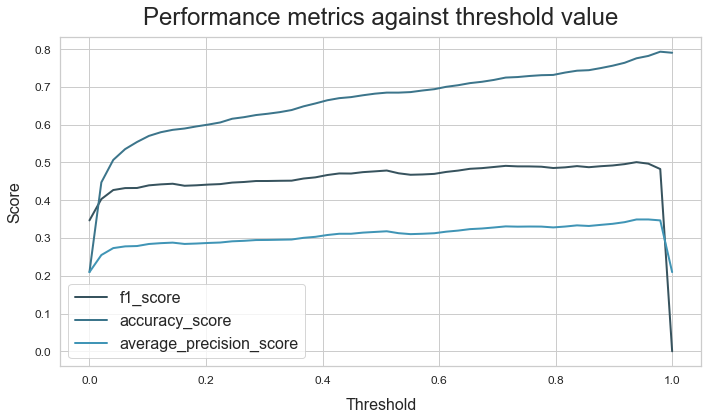

In [11]:
# Make some plots to analyze the results
atom.winner.plot_confusion_matrix(normalize=True, figsize=(7, 7), filename='confusion_matrix.png')
atom.winner.plot_probabilities()

# Change plots aesthetics
ATOMClassifier.set_style('whitegrid')
ATOMClassifier.set_title_fontsize(24)

atom.plot_ROC(models=('LGB', 'CatB'), title="ROC for the LightGBM vs CatBoost model")
atom.plot_PRC(title="PRC comparison of the models")
atom.catb.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')